# 06_anomaly detection
trying out different algorithms to detect unsuspected data

## content
* Package imports
* package loads
  * isolation forest
  


## package imports
* nutzung von PyOd Package anstatt sklearn
* ist built on top of SK Learn


In [1]:
import sys
import os

import yaml
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

from functions.utils import get_folder
from functions.data_loads import get_columns, load_data

curr_folder = get_folder()
parent_fold = curr_folder.parent
with open(parent_fold / "connections.yml", encoding='utf-8') as file:
    db_config = yaml.safe_load(file)
    
with open(parent_fold / "configurations" / "data_loads.yaml", encoding='utf-8') as file:
    column_conf = yaml.safe_load(file)
    
engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["db"]}')

dates = ["01.05.2022","05.05.2022"]

In [2]:
columns = get_columns(engine,'tbl_positionagg',column_conf['position_unrel_cols'])
print(columns)
data = load_data(engine,'tbl_positionagg',columns)
data['msgtime'] = pd.to_datetime(data['msgtime'])
data['date'] = pd.to_datetime(data['date'])
data[['lat_merc_x','lon_merc_x']] = data[['lat_merc_x','lon_merc_x']].round(2)

['aisclass_count', 'aisclass_count_l_hour', 'date', 'dow', 'hod', 'lat_merc_x', 'lat_merc_y', 'lon_merc_x', 'lon_merc_y', 'mmsi_nunique', 'mmsi_nunique_l_hour', 'msgtime', 'sog_max', 'sog_max_l_hour', 'sog_mean', 'sog_mean_l_hour', 'sog_min', 'sog_min_l_hour', 'sog_std', 'sog_std_l_hour']


## isolation forest

In [3]:
X_train = data[['aisclass_count', 'aisclass_count_l_hour', 'mmsi_nunique', 'mmsi_nunique_l_hour', 'sog_max', 'sog_max_l_hour',
                'sog_mean', 'sog_mean_l_hour', 'sog_min', 'sog_min_l_hour', 'sog_std', 'sog_std_l_hour']][data.date == '2022-06-03']

clf = IForest()
clf.fit(X_train)
y_predictions = clf.predict(X_train)


In [4]:
# example of the feature importance
feature_importance = clf.feature_importances_
print("Feature importance", feature_importance)


Feature importance [0.07221731 0.10286971 0.06118657 0.08150277 0.10413463 0.08893468
 0.09158041 0.08786213 0.07793657 0.07320332 0.10014558 0.05842633]


In [5]:
output_data = data[data.date == '2022-06-03']
output_data['predictions'] = y_predictions

<ipython-input-5-e9bfcf1abe68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_data['predictions'] = y_predictions


<AxesSubplot:xlabel='msgtime'>

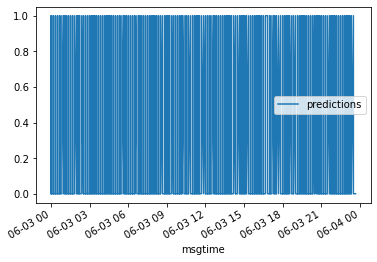

In [6]:
output_data[['msgtime','predictions']].plot(x='msgtime')

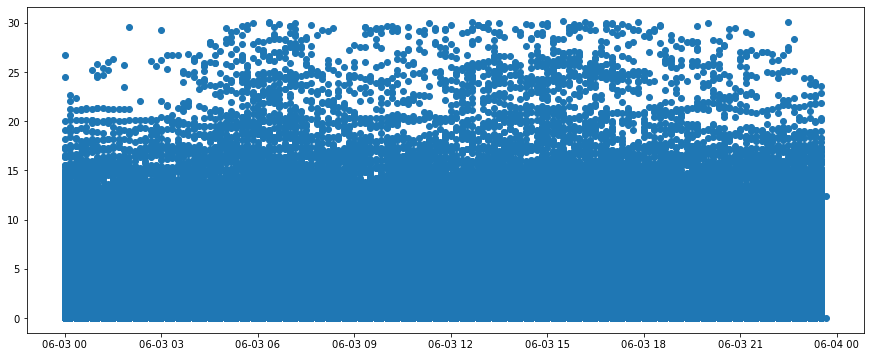

In [7]:
plt.figure(figsize=(15,6))
plt.plot_date(output_data['msgtime'],output_data['sog_mean'])

<ipython-input-15-10ed0b8a27b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_data['color'] = output_data['predictions'].replace({0:'red',1:'green'})


<AxesSubplot:xlabel='msgtime', ylabel='sog_mean'>

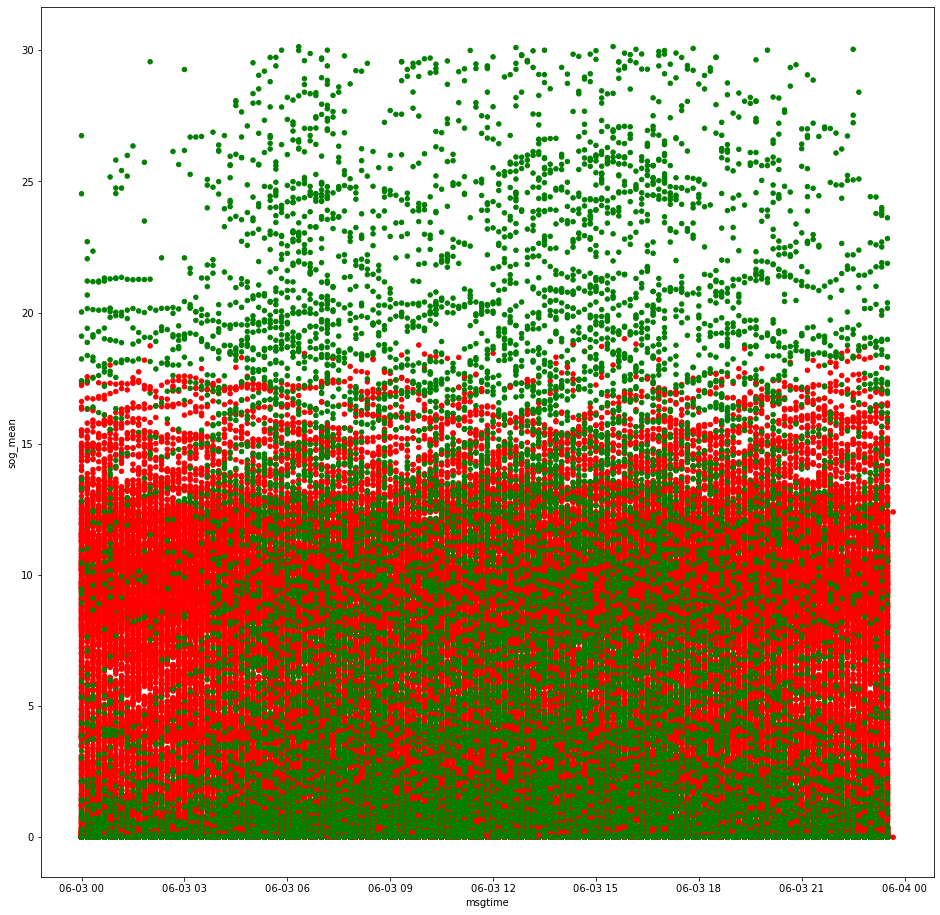

In [15]:

output_data['color'] = output_data['predictions'].replace({0:'red',1:'green'})
output_data[['msgtime','sog_mean','color']].plot(kind='scatter',x='msgtime',y='sog_mean', c='color',figsize=(16,16))

AttributeError: 'AxesSubplot' object has no attribute 'ticks'

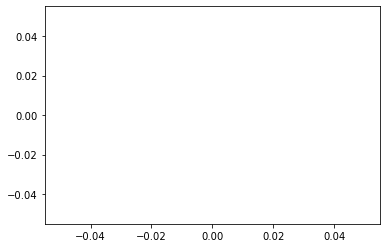

In [9]:
# Plot
output_group = output_data.groupby(['predictions'])
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.ticks(range(0,len(output_data['msgtime'])), output_group.msgtime)
for group in output_group:
    ax.plot(y= output_group.sog_mean, marker='o', linestyle='', ms=12, label=group)
ax.legend()

plt.show()